# Quantum Generative Adversarial Networks

Below are notes from each section of the qiskit course documentation found on this page: https://learn.qiskit.org/course/machine-learning/quantum-generative-adversarial-networks

## Introduction

GANs are one of the most prominent unsupervised learning methods as of recently.

## Classical generative models (theory)

### Generative models

While supervised models learning the relationship between input and output, generative models try to underrstand the data itself. This can be a much more difficult task because there are sometimes key features that are a giveaway for a certain label/category in supervised learning whereas the learning is more nuanced for GANs as they try to learn the underlying _creator_ function. THe goal is to learn/reproduce the probability distribution that created the training data.

### The generator

One component of GANs are generators and their primary aim is to create fake data that is convincing enough for the discriminator to label as real. In orderr to allow the generator to explore a rich space of output non-deterministically, a random noise vector is drawn and fed into the generator as input. The generator succeeds once it learns how to map most points in the latent space (Gaussian noise) onto convincing fake data samples fitting the real distribution. 

### The discriminator

The discriminator is another component of the GAN and it will receive data samples from both the generator and the real distribution (training data) and its goal is to correctly classify the input data samples as fake or real. This is direct contrast to the generator's goal so they work against each other; the discriminator tries to minimize the probability of misclassifying the fake data as real while the generator tries to maximize it.

![image gan](./gan_general_flow.svg)

### Convergence

The GAN converges once it can no longer tell the difference between the generated data and the real data, known as the Nash equilibrium (from game theory). At this point, it randomly guesses fake/real with equal probability.

## Quantum Generative Adversarial Networks (Theory)

In general, QGANs can be used for the discriminator, the generator, or both components using parameterized quantum circuits. This chapter will discuss QGANs that implement both components. QGANs and GANs operate very similarly in their training phase; the generator and discriminator are trained alternatively with the other component's parameter's fixed. Additionally, the stable equilibrium occurs when the generator produces data identical to a target distribution.

The objective of a fully quantum QGAN is for the generator to produce a desired state $\ket{\psi}$ and achieves this through iterative updates to its parameters. However, in the case of a QGAN, the generator's cost function landscape evolves and becomes _betterr_ as the descriminator improves at recognizing real samples. Let's look at some general circuit schematics below:

![image real](./real_rig.svg)
![image fake](./fake_rig.svg)

The discriminator acts on the data sample (real or fake) and an additional qubit $\ket{0}$ and the last qubit is measured with the outcome corresponding to $\ket{0}$ (real) or $\ket{1}$ (fake). Real data is transformed into a quantum state using a unitary $U_R$. The discrimnator should have some entangling gates to "transmit" relevant features of the real data to its register/workspace. The discriminators parameters are updated through a classical optimizer to minimize the expectation value of the last qubit.

In the case of fake data, a wave function is generated by $U_{G(\vec{\theta_G})}$ and then fed to the discriminator. The last qubit is also meausured here to get the expectation value which is the discriminator's score on the fake data. Overall, the GAN follows the minimax decision rule.

## Full Implementation I

### Learning a 2 qubit Bell state

We can now build an actual QGAN to learn the 2 qubit Bell state in qiskit.

In [1]:
import numpy as np
from qiskit import QuantumCircuit, Aer
from qiskit.visualization import plot_histogram

### Defining the real distribution

The 2 qubit Bell state is a maximally entangled quantum state and we want to reproduce the following state: $\ket{\psi} = \frac{1}{\sqrt{2}}(\ket{00} + \ket{11})$.

In [2]:
# Number of qubits needed to model real distribution
REAL_DIST_NQUBITS = 2
real_circuit = QuantumCircuit(REAL_DIST_NQUBITS)
real_circuit.h(0)
real_circuit.cx(0, 1);

### Defining the variational quantum generator and discriminator

First, we'll define the generator ansatz. Note that this research is still in its infancy so there isn't an established optimal ansatz, just some general guidelines. The most important to note though is that whatever ansatz we go with, it must be able to actually reproduce the real distribution. In terms that we've covered before, it must have enough _capacity_ and _expressibility_ to fully reproduce the real quantum state. So the ansatz used here may seem arbitrary but it at least will be very suffice for our 2-qubit Bell state.

In [3]:
# Import qiskit machine learning parameters
from qiskit.circuit import ParameterVector

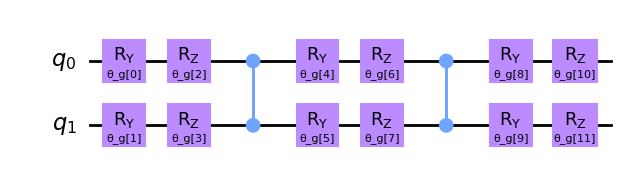

In [4]:
from qiskit.circuit.library import TwoLocal
generator = TwoLocal(REAL_DIST_NQUBITS,
                     # Parameterized single qubit rotations
                     ['ry', 'rz'],
                     'cz',  # Entangling gate
                     'full', # Entanglement structure: all to all
                     reps=2, # Number of layers
                     parameter_prefix='θ_g',
                     name='Generator')
generator = generator.decompose() # decompose into standard gates
generator.draw()

### Variational quantum discriminator

Now we define the ansatz for the discriminator. Instead of using TwoLocal (as above), we create a custom ansatz with a ParameterVector.

Note: Idk why a custom ansatz was needed versus some other out-of-the-box circuit but we did see this custom ansatz done in the very first section of the QML course so OK.

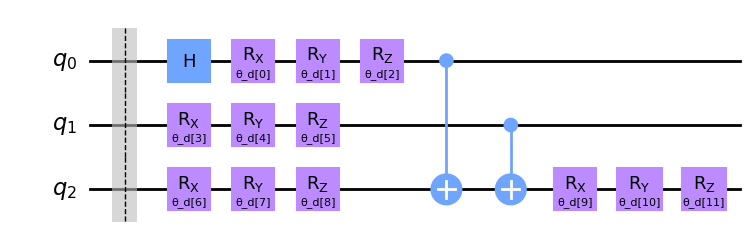

In [5]:
disc_weights = ParameterVector('θ_d', 12)
discriminator = QuantumCircuit(3, name="Discriminator")
discriminator.barrier()
discriminator.h(0)
discriminator.rx(disc_weights[0], 0)
discriminator.ry(disc_weights[1], 0)
discriminator.rz(disc_weights[2], 0)
discriminator.rx(disc_weights[3], 1)
discriminator.ry(disc_weights[4], 1)
discriminator.rz(disc_weights[5], 1)
discriminator.rx(disc_weights[6], 2)
discriminator.ry(disc_weights[7], 2)
discriminator.rz(disc_weights[8], 2)
discriminator.cx(0, 2)
discriminator.cx(1, 2)
discriminator.rx(disc_weights[9], 2)
discriminator.ry(disc_weights[10], 2)
discriminator.rz(disc_weights[11], 2)
discriminator.draw()

### Compiling the QGAN

Now we can construct the two circuits forming the QGAN. Our first circuit is the generator circuit + the  discriminator circuit whereas the second circuit is the real data + discriminator.

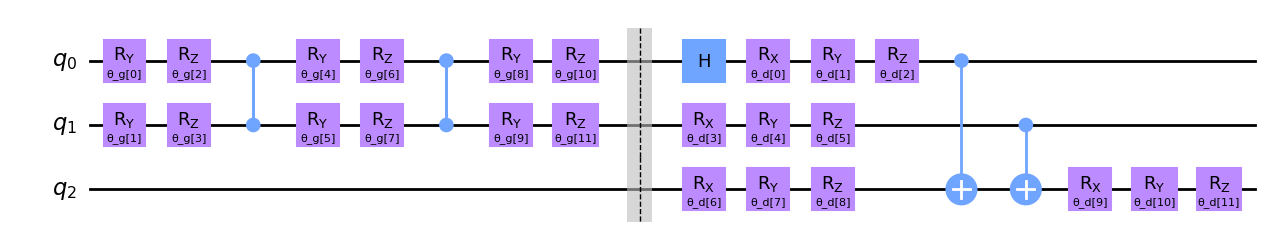

In [6]:
N_GPARAMS = generator.num_parameters
N_DPARAMS = discriminator.num_parameters
# Need extra qubit for the discriminator
gen_disc_circuit = QuantumCircuit(REAL_DIST_NQUBITS+1)
gen_disc_circuit.compose(generator, inplace=True)
gen_disc_circuit.compose(discriminator, inplace=True)
gen_disc_circuit.draw()

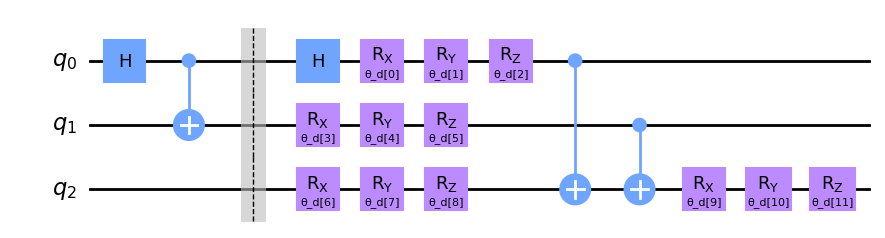

In [7]:
real_disc_circuit = QuantumCircuit(REAL_DIST_NQUBITS+1)
real_disc_circuit.compose(real_circuit, inplace=True)
real_disc_circuit.compose(discriminator, inplace=True)
real_disc_circuit.draw()

<font color="red">Question:</font>The qiskit documentation talks about the missing ingredient from the classical GAN counterpart is nosie being fed into the generator. The qiskit documentation talks about this have less of an obvious impact...I'm not entirely sure I understand it so come back to this later.

### Constructing the cost function

In [8]:
def calculate_kl_div(model_distribution: dict, target_distribution: dict):
    """Gauge model performance using Kullback Leibler Divergence"""
    kl_div = 0
    for bitstring, p_data in target_distribution.items():
        if np.isclose(p_data, 0, atol=1e-8):
            continue
        if bitstring in model_distribution.keys():
            kl_div += (p_data * np.log(p_data)
                 - p_data * np.log(model_distribution[bitstring]))
        else:
            kl_div += p_data * np.log(p_data) - p_data * np.log(1e-6)
    return kl_div

### CircuitQNN

In [9]:
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.neural_networks import CircuitQNN

# define quantum instances (statevector and sample based)
qi_sv = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

# specify QNN to update generator weights
gen_qnn = CircuitQNN(gen_disc_circuit,  # parameterized circuit
                     # frozen input arguements (discriminator weights)
                     gen_disc_circuit.parameters[:N_DPARAMS],
                     # differentiable weights (generator weights)
                     gen_disc_circuit.parameters[N_DPARAMS:],
                     sparse=True, # returns sparse probability vector
                     quantum_instance=qi_sv)

# specify QNNs to update discriminator weights
disc_fake_qnn = CircuitQNN(gen_disc_circuit, # parameterized circuit
                           # frozen input arguments (generator weights)
                           gen_disc_circuit.parameters[N_DPARAMS:],
                           # differentiable weights (discrim. weights)
                           gen_disc_circuit.parameters[:N_DPARAMS],
                           sparse=True, # get sparse probability vector
                           quantum_instance=qi_sv)

disc_real_qnn = CircuitQNN(real_disc_circuit, # parameterized circuit
                           [], # no input parameters
                           # differentiable weights (discrim. weights)
                           gen_disc_circuit.parameters[:N_DPARAMS],
                           sparse=True, # get sparse probability vector
                           quantum_instance=qi_sv)

/var/folders/f6/glc4hjkn44gg3qtb6mq_88kc0000gq/T/ipykernel_47720/2636737345.py:5: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  qi_sv = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))


In [ ]:
import tensorflow as tf
import pickle # to serialize and deserialize variables
# Initialize parameters
init_gen_params = np.random.uniform(low=-np.pi,
                                    high=np.pi,
                                    size=(N_GPARAMS,))
init_disc_params = np.random.uniform(low=-np.pi,
                                     high=np.pi,
                                     size=(N_DPARAMS,))
gen_params = tf.Variable(init_gen_params)
disc_params = tf.Variable(init_disc_params)

In [ ]:
init_gen_circuit = generator.bind_parameters(init_gen_params)
init_prob_dict = Statevector(init_gen_circuit).probabilities_dict()

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1, 1, sharey=True)
ax1.set_title("Initial generator distribution")
plot_histogram(init_prob_dict, ax=ax1)

In [ ]:
# Initialize Adam optimizer from Keras
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

### Training

In [ ]:
# Initialize variables to track metrics while training
best_gen_params = tf.Variable(init_gen_params)
gloss = []
dloss = []
kl_div = []

In [ ]:
TABLE_HEADERS = "Epoch | Generator cost | Discriminator cost | KL Div. |"
print(TABLE_HEADERS)
for epoch in range(100):
    #--- Quantum discriminator parameter updates ---#
    D_STEPS = 5 # N discriminator updates per generator update
    for disc_train_step in range(D_STEPS):
        # Partial derivatives wrt θ_D
        d_fake = disc_fake_qnn.backward(gen_params, disc_params
                                       )[1].todense()[0, 0b100:]
        d_fake = np.sum(d_fake, axis=0)
        d_real = disc_real_qnn.backward([], disc_params
                                       )[1].todense()[0, 0b100:]
        d_real = np.sum(d_real, axis=0)
        # Recall Cost_D structure
        grad_dcost = [d_fake[i] - d_real[i] for i in range(N_DPARAMS)]
        grad_dcost = tf.convert_to_tensor(grad_dcost)
        # Update disc params with gradient
        discriminator_optimizer.apply_gradients(zip([grad_dcost],
                                                    [disc_params]))
        # Track discriminator loss
        if disc_train_step % D_STEPS == 0:
            dloss.append(discriminator_cost(disc_params))

    #--- Quantum generator parameter updates ---#
    for gen_train_step in range(1):
        # Compute partial derivatives of prob(fake|true) wrt each
        # generator weight
        grads = gen_qnn.backward(disc_params, gen_params)
        grads = grads[1].todense()[0][0b100:]
        # Recall Cost_G structure and the linearity of
        # the derivative operation
        grads = -np.sum(grads, axis=0)
        grads = tf.convert_to_tensor(grads)
        # Update gen params with gradient
        generator_optimizer.apply_gradients(zip([grads], [gen_params]))
        gloss.append(generator_cost(gen_params))

    #--- Track KL and save best performing generator weights ---#
    # Create test circuit with updated gen parameters
    gen_checkpoint_circuit = generator.bind_parameters(gen_params.numpy())
    # Retrieve probability distribution of current generator
    gen_prob_dict = Statevector(gen_checkpoint_circuit
                               ).probabilities_dict()
    # Constant real probability distribution
    real_prob_dict = Statevector(real_circuit).probabilities_dict()
    current_kl = calculate_kl_div(gen_prob_dict, real_prob_dict)
    kl_div.append(current_kl)
    if np.min(kl_div) == current_kl:
        # New best
        # serialize & deserialize to simply ensure zero links
        best_gen_params = pickle.loads(pickle.dumps(gen_params))
    if epoch % 10 == 0:
        # print table every 10 epochs
        for header, val in zip(TABLE_HEADERS.split('|'),
                              (epoch, gloss[-1], dloss[-1], kl_div[-1])):
            print(f"{val:.3g} ".rjust(len(header)), end="|")
        print()

### Results visualized

In [ ]:
fig, (loss, kl) = plt.subplots(2, sharex=True,
                               gridspec_kw={'height_ratios': [0.75, 1]},
                               figsize=(6,4))
fig.suptitle('QGAN training stats')
fig.supxlabel('Training step')
loss.plot(range(len(gloss)), gloss, label="Generator loss")
loss.plot(range(len(dloss)), dloss, label="Discriminator loss",
          color="C3")
loss.legend()
loss.set(ylabel='Loss')
kl.plot(range(len(kl_div)), kl_div, label="KL Divergence (zero is best)",
        color="C1")
kl.set(ylabel='KL Divergence')
kl.legend()
fig.tight_layout();

In [ ]:
# Create test circuit with new parameters
gen_checkpoint_circuit = generator.bind_parameters(
    best_gen_params.numpy())
gen_prob_dict = Statevector(gen_checkpoint_circuit).probabilities_dict()
real_prob_dict = Statevector(real_circuit).probabilities_dict() # constant
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
plot_histogram(gen_prob_dict, ax=ax1)
ax1.set_title("Trained generator distribution")
plot_histogram(real_prob_dict, ax=ax2)
ax2.set_title("Real distribution")
fig.tight_layout()

## Full implementation II

### Learning a normal distribution with OpFlowQNN

### Defining the real distribution

### Defining the variational quantum discriminator and generator

### Compiling the QGAN

### OpflowQNN

### Reconstructing the cost function

### Training

### Results visualized

## Potential applications